In [ ]:
! pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 25.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which 

In [ ]:
from evaluation_suite import EvaluationSuite

In [ ]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
import pprint

from datasets import Dataset

from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    pipeline,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling
)

import torch

from peft import LoraConfig, get_peft_model, TaskType

import json
import pprint
import pprint
# Import weights and biases
import wandb
# Import kaggle secrets
from google.colab import userdata

# Load data

In [ ]:
with open('train_dataset.json', 'r') as f:
    train_dataset = json.load(f)

# Load test_dataset
with open('test_dataset.json', 'r') as f:
    test_dataset = json.load(f)

multiple_choice_testset = Dataset.from_list(test_dataset['multiple_choice'])
multiple_choice_trainset = Dataset.from_list(train_dataset['multiple_choice'])

In [ ]:
# Define a system prompt under prompt_style
prompt_style_multiple_choice = """
"{_question_var_}"

### What is the correct answer? Please state only the letter:
"""

def build_prompt(prompt_style: str, question: str):
  return prompt_style.replace("{_question_var_}", question)

In [ ]:
def generate_model_input(example):
    question = example['question']
    options = example['options']

    model_input = question + '\nOptions:\n'
    for key, val in options.items():
        model_input += f"{key}. {val}\n"

    example['model_input'] = build_prompt(prompt_style_multiple_choice, model_input)
    return example

In [ ]:
multiple_choice_testset = multiple_choice_testset.map(generate_model_input)
multiple_choice_trainset = multiple_choice_trainset.map(generate_model_input)

Map:   0%|          | 0/43466 [00:00<?, ? examples/s]

Map:   0%|          | 0/173861 [00:00<?, ? examples/s]

In [ ]:
def format(example):
    question = example["model_input"]
    output = example["correct_answer"]

    full_text = question + output

    return {"prompt": question, "output": output, "text": full_text}


In [ ]:
trainset = multiple_choice_trainset.map(format)
testset = multiple_choice_testset.map(format)

Map:   0%|          | 0/173861 [00:00<?, ? examples/s]

Map:   0%|          | 0/43466 [00:00<?, ? examples/s]

# Fine-tuning

In [ ]:
model_id = "deepseek-ai/deepseek-coder-7b-instruct-v1.5"
project_name = "CinIQ_fine-tuning"
run_name = "ft_multiple_choice_v4"

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.float16,
    trust_remote_code=True
)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.87k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.61M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/621 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/22.5k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/3.85G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/121 [00:00<?, ?B/s]

In [ ]:
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.CAUSAL_LM
)

In [ ]:
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()


trainable params: 3,932,160 || all params: 6,914,297,856 || trainable%: 0.0569


In [ ]:
wandb.init(project=project_name, name=run_name)

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: konstantinwehmeyer (konstantinwehmeyer-university-of-st-gallen-student-union) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
def tokenize(example):
    prompt_ids = tokenizer(
        example["prompt"],
        truncation=True,
        max_length=2048,
        padding="max_length"
    )

    full_ids = tokenizer(
        example["text"],
        truncation=True,
        max_length=2048,
        padding="max_length"
    )

    labels = full_ids["input_ids"].copy()

    # Mask the prompt tokens — we only want to train on the output
    prompt_len = len(tokenizer(example["prompt"])["input_ids"])
    labels[:prompt_len] = [-100] * prompt_len  # -100 = ignore index for loss

    full_ids["labels"] = labels
    return full_ids


In [ ]:
tokenized = trainset.map(tokenize, batched=True)
tokenized.set_format(type="torch", columns=["input_ids", "attention_mask"])

Map:   0%|          | 0/173861 [00:00<?, ? examples/s]

In [ ]:
training_args = TrainingArguments(
    output_dir="./deepseek-coder-lora",
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8,
    learning_rate=2e-4,
    num_train_epochs=3,
    fp16=True,
    logging_dir="./logs",
    logging_steps=5,
    save_steps=50,
    save_total_limit=2,
    report_to="wandb",  # W&B tracking
    run_name=run_name
)


In [ ]:
model.gradient_checkpointing_disable()

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized,
    tokenizer=tokenizer,
    data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False)
)

<ipython-input-20-839fc8cd66e5>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [ ]:
trainer.train()

Step,Training Loss
5,2.623400
10,2.453100
15,2.101700
20,1.845500
25,1.716600
30,1.529000
35,1.508500
40,1.525800
45,1.457200
50,1.462600


KeyboardInterrupt: 

In [ ]:
model.save_pretrained("./ft_multiple_choice_v3")
tokenizer.save_pretrained("./ft_multiple_choice_v3")

('./ft_multiple_choice_v3/tokenizer_config.json',
 './ft_multiple_choice_v3/special_tokens_map.json',
 './ft_multiple_choice_v3/tokenizer.json')

# Load fine-tuned model

In [ ]:
model_path = "./ft_multiple_choice_v3"

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto", torch_dtype=torch.float16)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

# Evaluate fine-tuned model

In [ ]:
multiple_choice_testset = test_dataset['multiple_choice']

for sample in multiple_choice_testset:
  question = sample.get('question')
  options = sample.get('options')
  model_input = question + '\n Options: '
  for option in options:
    model_input += option + '. ' +options[option] + '\n'

  multiple_choice_testset[multiple_choice_testset.index(sample)]['model_input'] = model_input

In [ ]:
# Define a system prompt under prompt_style
prompt_style_multiple_choice = """
"{_question_var_}"

### What is the correct answer? Please state only the letter:
"""

In [ ]:
pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)
response = pipe(build_prompt(prompt_style_multiple_choice, multiple_choice_testset[0]['model_input']))

Device set to use cuda:0


In [ ]:
pprint.pp(response)
print(multiple_choice_testset[0]['correct_answer'])

[{'generated_text': '\n'
                    '"Formation of one of the following is essential for '
                    'success of this instrument?\n'
                    ' Options: A. Caput\n'
                    'B. Chignon\n'
                    'C. Phlegmon\n'
                    'D. None of the above.\n'
                    '"\n'
                    '\n'
                    '### What is the correct answer? Please state only the '
                    'letter:\n'
                    'B\n'
                    '"\n'
                    '\n'
                    '### What is the correct answer? Please state only the '
                    'letter:\n'
                    'B'}]
B


In [ ]:
predictions_multiple_choice = []

for i in range(50):

  pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)
  response = pipe(build_prompt(prompt_style_multiple_choice, multiple_choice_testset[i]['model_input']))

  predictions_multiple_choice.append(response)

Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0


In [ ]:
import re
predicted_answer_multiple_choice = []
for sample in predictions_multiple_choice:
  match = re.search(r'Please state only the letter:\s*\n*([A-E])\.*', sample[0].get('generated_text'))
  if match:
      answer = match.group(1)
      predicted_answer_multiple_choice.append(answer)
  else:
      predicted_answer_multiple_choice.append("na")

ground_truth = [entry['correct_answer'] for entry in multiple_choice_testset[:50]]

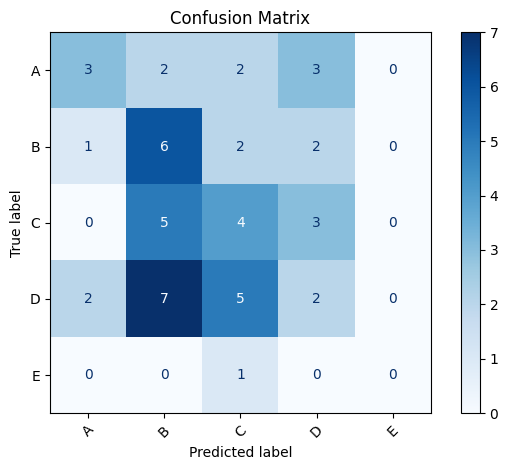

{'accuracy': 0.3,
 'precision': 0.2571428571428572,
 'recall': 0.26075757575757574}

In [ ]:
ground_truth = [entry['correct_answer'] for entry in multiple_choice_testset[:50]]

evaluation_suite = EvaluationSuite()

evaluation_suite.evaluate_MC(predicted_answer_multiple_choice, ground_truth)